In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from datasets import load_dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Dataset Preprocessing and Loading

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.08),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [4]:
def apply_train_transform(example):
    images = example['image']

    if isinstance(images, list):
      # batch mode - transform each image in the list
      transformed = []
      for img in images:
        if img.mode != 'RGB':
          img = img.convert('RGB')
        transformed.append(train_transform(img))
      example['image'] = transformed
    else:
      # single image mode
      if img.mode != 'RGB':
        img = img.convert('RGB')
      example['image'] = train_transform(images)

    return example

def apply_eval_transform(example):
    images = example['image']

    if isinstance(images, list):
      # batch mode - transform each image in the list
      transformed = []
      for img in images:
        if img.mode != 'RGB':
          img = img.convert('RGB')
        transformed.append(eval_transform(img))
      example['image'] = transformed
    else:
      # single image mode
      if img.mode != 'RGB':
        img = img.convert('RGB')
      example['image'] = eval_transform(images)

    return example

In [5]:
train_dataset = load_dataset("tanganke/stanford_cars", split="train")
test_dataset = load_dataset("tanganke/stanford_cars", split="test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
print("Training set length:", len(train_dataset))
print("Test set length", len(test_dataset))

Training set length: 8144
Test set length 8041


In [7]:
# split the training set to 80% training and 20% validation sets

train_size = int(0.8 * len(train_dataset))

indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_split = train_dataset.select(train_indices)
val_split = train_dataset.select(val_indices)

In [8]:
# apply transformations on each set

train_data = train_split.with_transform(apply_train_transform)
val_data = val_split.with_transform(apply_eval_transform)
test_data = test_dataset.with_transform(apply_eval_transform)

In [9]:
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 6515
Validation samples: 1629
Test samples: 8041


In [10]:
def collate_fn(batch):
  images = torch.stack([item['image'] for item in batch])
  labels = torch.tensor([item['label'] for item in batch])
  return images, labels

In [11]:
train_loader = DataLoader(train_data, batch_size=32,
                         shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32,
                       shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32,
                        shuffle=False, num_workers=0, collate_fn=collate_fn)

# Model Architecture

In [12]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 196)
)

model = model.to(device)

In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Model Training

Training the model in two phases: <br>


1.   Freeze the backbone layers and train only the fully connected layers (feature extraction)
2.   Fine-tune the entire model


In [14]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

def train_epoch(optimizer):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in tqdm(train_loader, desc="Training"):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()

    running_loss += loss.item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = (correct / total) * 100

  return epoch_loss, epoch_acc

def validate():
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Validation"):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _, preds = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()

      running_loss += loss.item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = (correct / total) * 100

  return epoch_loss, epoch_acc

def train_model(num_epochs, optimizer, scheduler, patience=0):
  history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
  }

  best_val_loss = float('inf')
  patience_counter = 0

  for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(optimizer)
    val_loss, val_acc = validate()

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # implement early stopping
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      patience_counter = 0
      torch.save(model.state_dict(), "best_model.pth")
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

  return history

## Phase 1: Training only FC layers (feature extraction)

In [15]:
# freeze only the parameters of the backbone model
for param in model.parameters():
  param.requires_grad = False

for param in model.fc.parameters():
  param.requires_grad = True

optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay = 0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_model(30, optimizer, scheduler, patience=10)


Epoch 1/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.15it/s]


Train Loss: 4.9593, Train Acc: 4.22%
Val Loss: 4.3969, Val Acc: 8.04%

Epoch 2/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.20it/s]


Train Loss: 4.1860, Train Acc: 12.19%
Val Loss: 3.9100, Val Acc: 13.57%

Epoch 3/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.15it/s]


Train Loss: 3.8194, Train Acc: 17.41%
Val Loss: 3.6738, Val Acc: 17.31%

Epoch 4/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.18it/s]


Train Loss: 3.5841, Train Acc: 21.73%
Val Loss: 3.5083, Val Acc: 20.81%

Epoch 5/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.16it/s]


Train Loss: 3.4235, Train Acc: 24.33%
Val Loss: 3.4004, Val Acc: 22.84%

Epoch 6/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.17it/s]


Train Loss: 3.3200, Train Acc: 27.01%
Val Loss: 3.3479, Val Acc: 24.80%

Epoch 7/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.18it/s]


Train Loss: 3.2014, Train Acc: 28.44%
Val Loss: 3.2794, Val Acc: 25.91%

Epoch 8/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.16it/s]


Train Loss: 3.1084, Train Acc: 31.62%
Val Loss: 3.2764, Val Acc: 26.58%

Epoch 9/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.18it/s]


Train Loss: 3.0554, Train Acc: 32.43%
Val Loss: 3.2090, Val Acc: 27.32%

Epoch 10/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.19it/s]


Train Loss: 2.9984, Train Acc: 33.49%
Val Loss: 3.2077, Val Acc: 26.27%

Epoch 11/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.13it/s]


Train Loss: 2.9456, Train Acc: 34.14%
Val Loss: 3.1790, Val Acc: 27.38%

Epoch 12/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.14it/s]


Train Loss: 2.8992, Train Acc: 35.70%
Val Loss: 3.1426, Val Acc: 30.14%

Epoch 13/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.14it/s]


Train Loss: 2.8671, Train Acc: 36.24%
Val Loss: 3.1228, Val Acc: 29.59%

Epoch 14/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.17it/s]


Train Loss: 2.8266, Train Acc: 37.10%
Val Loss: 3.1333, Val Acc: 29.65%

Epoch 15/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.17it/s]


Train Loss: 2.7860, Train Acc: 37.42%
Val Loss: 3.0985, Val Acc: 30.69%

Epoch 16/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.18it/s]


Train Loss: 2.7493, Train Acc: 38.53%
Val Loss: 3.0889, Val Acc: 31.18%

Epoch 17/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.12it/s]


Train Loss: 2.7312, Train Acc: 39.11%
Val Loss: 3.0993, Val Acc: 30.20%

Epoch 18/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.13it/s]


Train Loss: 2.7029, Train Acc: 39.57%
Val Loss: 3.0681, Val Acc: 31.43%

Epoch 19/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.16it/s]


Train Loss: 2.6643, Train Acc: 39.91%
Val Loss: 3.0977, Val Acc: 30.33%

Epoch 20/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.13it/s]


Train Loss: 2.6401, Train Acc: 41.15%
Val Loss: 3.1326, Val Acc: 29.53%

Epoch 21/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.16it/s]


Train Loss: 2.6214, Train Acc: 41.15%
Val Loss: 3.0475, Val Acc: 31.55%

Epoch 22/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.15it/s]


Train Loss: 2.6022, Train Acc: 41.80%
Val Loss: 3.0374, Val Acc: 32.47%

Epoch 23/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.15it/s]


Train Loss: 2.5996, Train Acc: 42.16%
Val Loss: 3.0203, Val Acc: 32.29%

Epoch 24/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.17it/s]


Train Loss: 2.5694, Train Acc: 42.49%
Val Loss: 3.0383, Val Acc: 32.35%

Epoch 25/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.18it/s]


Train Loss: 2.5278, Train Acc: 43.53%
Val Loss: 3.0249, Val Acc: 32.35%

Epoch 26/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.19it/s]


Train Loss: 2.5503, Train Acc: 42.96%
Val Loss: 3.0287, Val Acc: 31.00%

Epoch 27/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.16it/s]


Train Loss: 2.4945, Train Acc: 44.22%
Val Loss: 3.0236, Val Acc: 32.41%

Epoch 28/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.13it/s]


Train Loss: 2.5027, Train Acc: 44.02%
Val Loss: 3.0426, Val Acc: 32.66%

Epoch 29/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.11it/s]


Train Loss: 2.4653, Train Acc: 45.68%
Val Loss: 3.0208, Val Acc: 33.82%

Epoch 30/30


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.12it/s]


Train Loss: 2.3790, Train Acc: 47.67%
Val Loss: 2.9560, Val Acc: 34.07%


{'train_loss': [4.959277758411333,
  4.186030808617087,
  3.8193832635879517,
  3.5840875179159877,
  3.423514049427182,
  3.320004546174816,
  3.201445625108831,
  3.1084489658767103,
  3.055420574019937,
  2.998381856609793,
  2.9456469147813085,
  2.8991924535994436,
  2.8670915458716597,
  2.8266293792163624,
  2.7860486261984883,
  2.749274016595354,
  2.7312271583314036,
  2.702936008864758,
  2.664342590406829,
  2.640110194683075,
  2.6213532154466592,
  2.602218397107779,
  2.5996108277171266,
  2.5693739775349114,
  2.5277768484517638,
  2.5502846977289986,
  2.494514398130716,
  2.5027144428561714,
  2.4652965641489217,
  2.378959295212054],
 'train_acc': [4.22102839600921,
  12.187260168841135,
  17.40598618572525,
  21.7344589409056,
  24.328472755180353,
  27.014581734458943,
  28.442056792018416,
  31.619339984650807,
  32.432847275518036,
  33.491941673062165,
  34.136607828089026,
  35.702225633154264,
  36.23944742900997,
  37.09900230237913,
  37.421335379892554,
  3

## Phase 2: Fine-tuning the entire model

In [18]:
# unfreeze all parameters of the model
for param in model.parameters():
  param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

patience_counter = 0
history = train_model(15, optimizer, scheduler, patience=10)


Epoch 1/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.13it/s]


Train Loss: 2.0679, Train Acc: 56.32%
Val Loss: 2.4642, Val Acc: 44.87%

Epoch 2/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.15it/s]


Train Loss: 1.7422, Train Acc: 66.28%
Val Loss: 2.2858, Val Acc: 49.54%

Epoch 3/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.14it/s]


Train Loss: 1.5965, Train Acc: 71.24%
Val Loss: 2.1525, Val Acc: 52.30%

Epoch 4/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.07it/s]


Train Loss: 1.4718, Train Acc: 74.84%
Val Loss: 2.0389, Val Acc: 56.97%

Epoch 5/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.01it/s]


Train Loss: 1.3837, Train Acc: 78.08%
Val Loss: 2.0078, Val Acc: 56.72%

Epoch 6/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.16it/s]


Train Loss: 1.2933, Train Acc: 81.20%
Val Loss: 1.9621, Val Acc: 58.44%

Epoch 7/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.10it/s]


Train Loss: 1.2244, Train Acc: 83.82%
Val Loss: 1.8910, Val Acc: 60.22%

Epoch 8/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.14it/s]


Train Loss: 1.1870, Train Acc: 84.85%
Val Loss: 1.8772, Val Acc: 61.82%

Epoch 9/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.13it/s]


Train Loss: 1.1221, Train Acc: 86.77%
Val Loss: 1.8157, Val Acc: 62.68%

Epoch 10/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.15it/s]


Train Loss: 1.0744, Train Acc: 88.56%
Val Loss: 1.7844, Val Acc: 64.76%

Epoch 11/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.14it/s]


Train Loss: 1.0375, Train Acc: 89.59%
Val Loss: 1.7644, Val Acc: 64.64%

Epoch 12/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.15it/s]


Train Loss: 1.0028, Train Acc: 90.58%
Val Loss: 1.7282, Val Acc: 65.68%

Epoch 13/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.16it/s]


Train Loss: 0.9700, Train Acc: 91.51%
Val Loss: 1.7185, Val Acc: 65.81%

Epoch 14/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.15it/s]


Train Loss: 0.9537, Train Acc: 92.66%
Val Loss: 1.7023, Val Acc: 66.05%

Epoch 15/15


Validation: 100%|██████████| 51/51 [00:12<00:00,  4.09it/s]


Train Loss: 0.9267, Train Acc: 93.37%
Val Loss: 1.6913, Val Acc: 66.24%


In [19]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

# Model Evaluation

In [21]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # loss plot
  ax1.plot(history['train_loss'], label='Train Loss')
  ax1.plot(history['val_loss'], label='Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('Training and Validation Loss')
  ax1.legend()
  ax1.grid(True)

  # accuracy plot
  ax2.plot(history['train_acc'], label='Train Accuracy')
  ax2.plot(history['val_acc'], label='Validation Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy (%)')
  ax2.set_title('Training and Validation Accuracy')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()

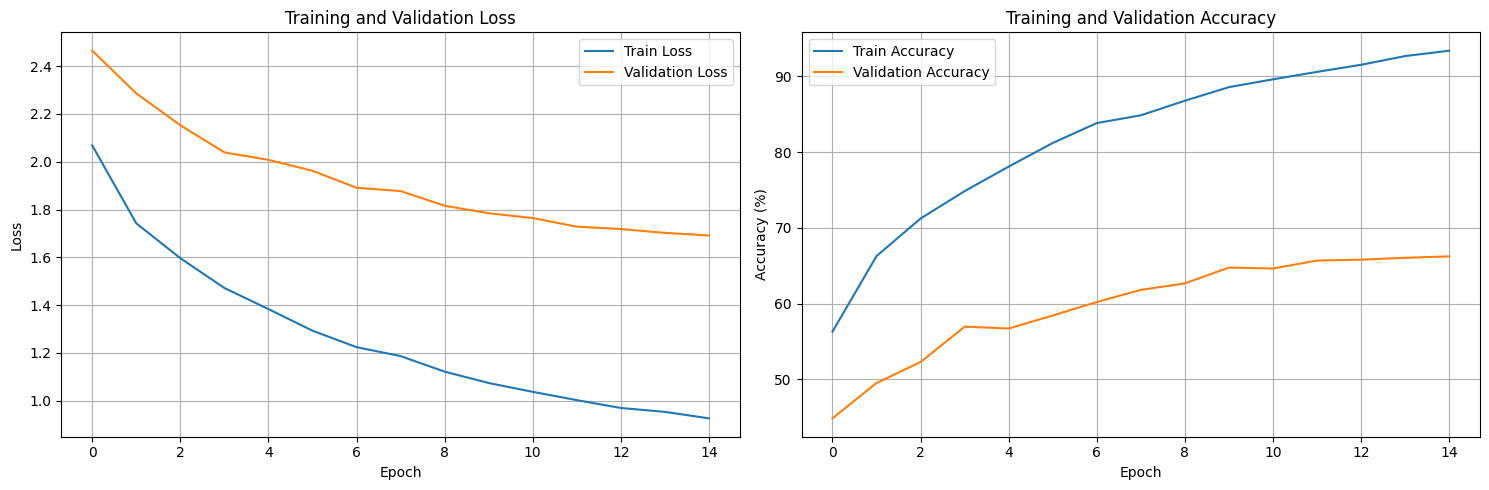

In [22]:
plot_training_history(history)

# Final Model Testing

Testing the trained model on the test set.

In [23]:
def test_model(test_loader):
  model.eval()
  all_preds = []
  all_labels = []
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = outputs.max(1)

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

  accuracy = 100. * correct / total
  print(f"\nTest Accuracy: {accuracy:.2f}%")

  # Classification report
  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds,
                              target_names=train_dataset.features['label'].names,
                              digits=4))

  return all_labels, all_preds, accuracy

In [24]:
labels, preds, accuracy = test_model(test_loader)

Testing: 100%|██████████| 252/252 [01:01<00:00,  4.07it/s]


Test Accuracy: 68.30%

Classification Report:
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.8511    0.9091    0.8791        44
                                   Acura RL Sedan 2012     0.5172    0.4688    0.4918        32
                                   Acura TL Sedan 2012     0.7778    0.6512    0.7089        43
                                  Acura TL Type-S 2008     0.5789    0.7857    0.6667        42
                                  Acura TSX Sedan 2012     0.7778    0.5250    0.6269        40
                             Acura Integra Type R 2001     0.7500    0.4773    0.5833        44
                              Acura ZDX Hatchback 2012     0.8077    0.5385    0.6462        39
              Aston Martin V8 Vantage Convertible 2012     0.5306    0.5778    0.5532        45
                    Aston Martin V8 Vantage Coupe 2012     0.6538    0.4146    0.5075   

In [25]:
def plot_per_class_metrics(labels, preds, class_names):
  from sklearn.metrics import precision_recall_fscore_support

  # Calculate metrics per class
  precision, recall, f1, support = precision_recall_fscore_support(
      labels, preds, labels=range(len(class_names)), zero_division=0
  )

  # Create DataFrame for easier handling
  metrics_data = []
  for i, class_name in enumerate(class_names):
    if support[i] > 0:  # Only include classes that appear in test set
      metrics_data.append({
          'class': class_name,
          'precision': precision[i],
          'recall': recall[i],
          'f1': f1[i],
          'support': support[i]
      })

  # Sort by F1-score
  metrics_data.sort(key=lambda x: x['f1'], reverse=True)

  print("\n Top 10 Best Performing Classes (by F1-score):")
  print(f"{'Rank':<6}{'Class':<50}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'Support':<10}")
  for i, data in enumerate(metrics_data[:10], 1):
      print(f"{i:<6}{data['class'][:48]:<50}{data['precision']*100:>10.1f}% {data['recall']*100:>10.1f}% {data['f1']*100:>10.1f}% {int(data['support']):>8}")

  print("\n Top 10 Worst Performing Classes (by F1-score):")
  print(f"{'Rank':<6}{'Class':<50}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'Support':<10}")
  for i, data in enumerate(metrics_data[-10:][::-1], 1):
      print(f"{i:<6}{data['class'][:48]:<50}{data['precision']*100:>10.1f}% {data['recall']*100:>10.1f}% {data['f1']*100:>10.1f}% {int(data['support']):>8}")

  # Calculate overall statistics
  avg_precision = np.mean([data['precision'] for data in metrics_data])
  avg_recall = np.mean([data['recall'] for data in metrics_data])
  avg_f1 = np.mean([data['f1'] for data in metrics_data])

  print("\n Overall Statistics:")
  print(f"   Average Precision: {avg_precision*100:.2f}%")
  print(f"   Average Recall:    {avg_recall*100:.2f}%")
  print(f"   Average F1-Score:  {avg_f1*100:.2f}%")
  print(f"   Total Test Samples: {sum(data['support'] for data in metrics_data)}")

  # Plot distribution of F1-scores
  fig, ax = plt.subplots(figsize=(12, 6))

  f1_scores = [d['f1'] * 100 for d in metrics_data]
  ax.hist(f1_scores, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
  ax.axvline(avg_f1 * 100, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_f1*100:.1f}%')
  ax.set_xlabel('F1-Score (%)', fontsize=12)
  ax.set_ylabel('Number of Classes', fontsize=12)
  ax.set_title('Distribution of Per-Class F1-Scores', fontsize=14, weight='bold')
  ax.legend(fontsize=11)
  ax.grid(axis='y', alpha=0.3)

  plt.tight_layout()


 Top 10 Best Performing Classes (by F1-score):
Rank  Class                                             Precision   Recall      F1-Score    Support   
1     Chevrolet HHR SS 2010                                  100.0%       91.7%       95.7%       36
2     Infiniti QX56 SUV 2011                                 100.0%       90.6%       95.1%       32
3     Jeep Wrangler SUV 2012                                  89.4%       97.7%       93.3%       43
4     Lamborghini Diablo Coupe 2001                           88.9%       90.9%       89.9%       44
5     MINI Cooper Roadster Convertible 2012                   93.9%       86.1%       89.9%       36
6     Ford E-Series Wagon Van 2012                            91.4%       86.5%       88.9%       37
7     AM General Hummer SUV 2000                              85.1%       90.9%       87.9%       44
8     Chrysler PT Cruiser Convertible 2008                    88.6%       86.7%       87.6%       45
9     Nissan NV Passenger Van 2012       

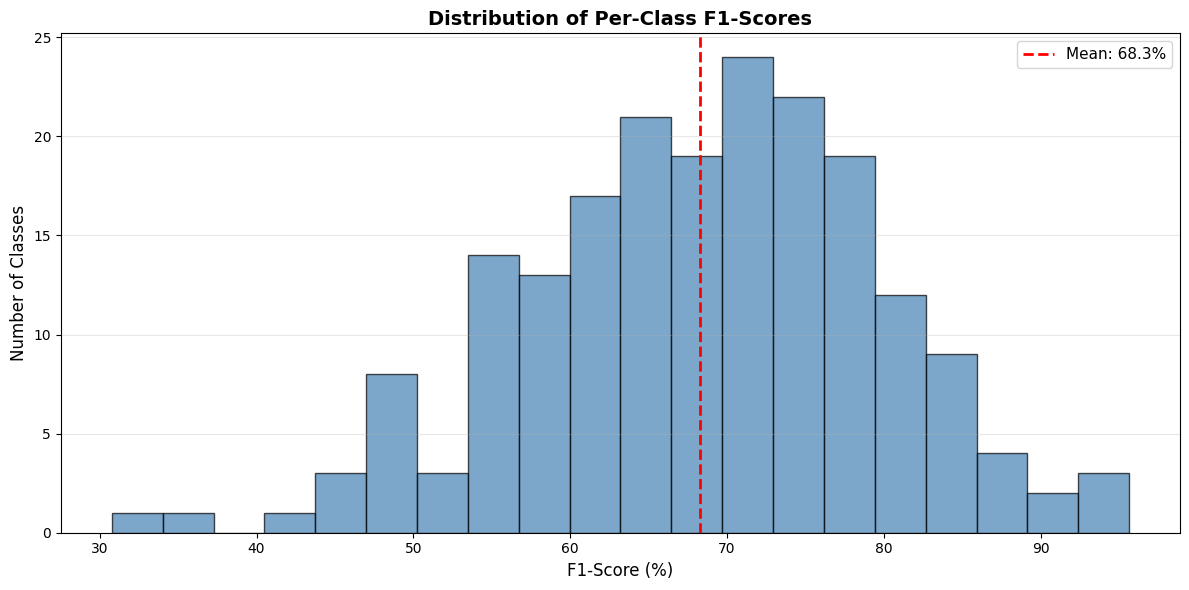

In [26]:
plot_per_class_metrics(labels, preds, train_dataset.features['label'].names)

# Visualizing Predictions

In [27]:
def visualize_predictions(model, test_loader, class_names, num_images=16):
  model.eval()

  all_images = []
  all_labels = []
  all_preds = []

  with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      # Move to CPU and store
      all_images.extend(inputs.cpu())
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(preds.cpu().numpy())

  total_samples = len(all_images)
  indices = np.random.choice(total_samples, min(num_images, total_samples), replace=False)

  # select sampled images
  sampled_images = [all_images[i] for i in indices]
  sampled_labels = [all_labels[i] for i in indices]
  sampled_preds = [all_preds[i] for i in indices]

  # plot images
  rows = 4
  cols = 4
  fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

  for idx in range(min(num_images, len(sampled_images))):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]

    # denormalize image
    img = sampled_images[idx].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # display image
    ax.imshow(img)
    ax.axis('off')

    # Get labels
    true_label = class_names[sampled_labels[idx]]
    pred_label = class_names[sampled_preds[idx]]

    # Color: green if correct, red if wrong
    color = 'green' if sampled_labels[idx] == sampled_preds[idx] else 'red'

    # Shorten label names for display
    true_label_short = true_label[:30] + '...' if len(true_label) > 30 else true_label
    pred_label_short = pred_label[:30] + '...' if len(pred_label) > 30 else pred_label

    # Title with true and predicted labels
    title = f"True: {true_label_short}\nPred: {pred_label_short}"
    ax.set_title(title, fontsize=10, color=color, weight='bold')

  plt.tight_layout()

  # calculate accuracy for these samples
  correct = sum([1 for i in range(len(sampled_images)) if sampled_labels[i] == sampled_preds[i]])
  print(f"\nAccuracy on visualized samples: {correct}/{len(sampled_images)} ({(correct/len(sampled_images))*100:.1f}%)")

Testing: 100%|██████████| 252/252 [01:02<00:00,  4.04it/s]



Accuracy on visualized samples: 11/16 (68.8%)


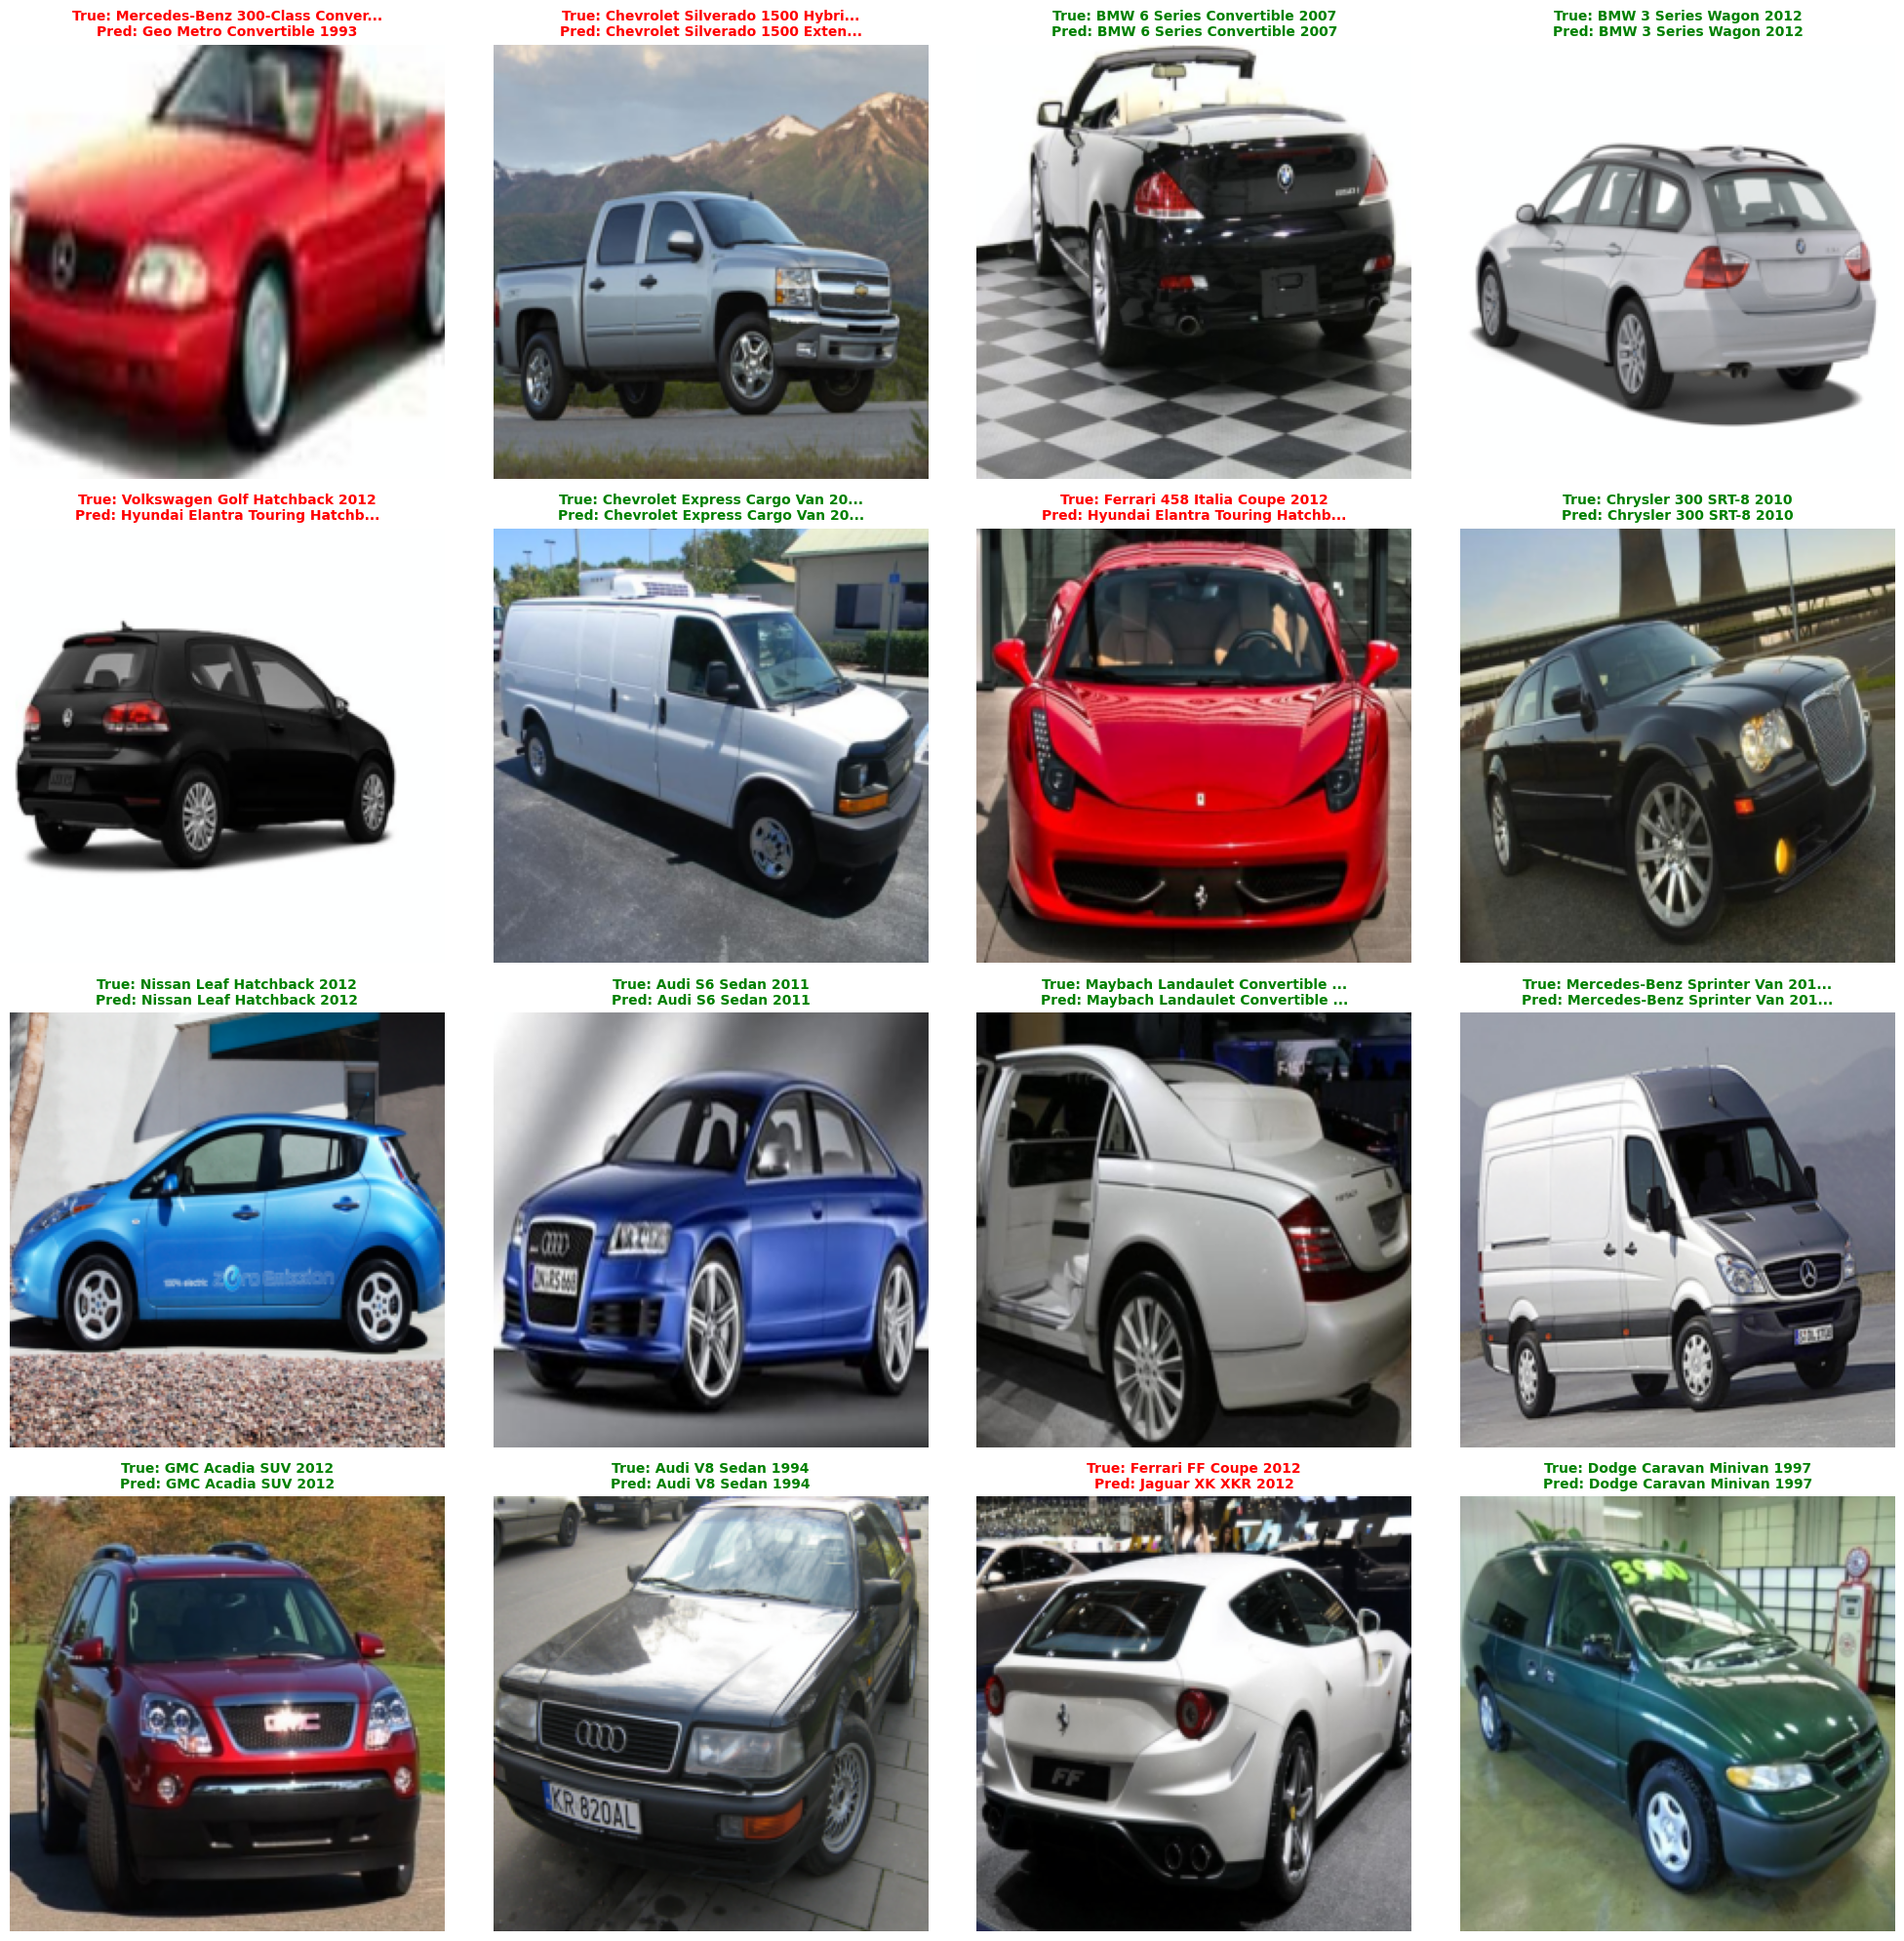

In [29]:
visualize_predictions(model, test_loader, train_dataset.features['label'].names, num_images=16)